In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 2000000
#maxEvents = 500000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4)
eta_bins = eta_bins[::-1]
#pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)
pt_bins = (-0.5 , -0.333333, -0.24, -0.15, -0.07, 0.07, 0.15, 0.24, 0.333333, 0.5)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)
superstrip_size = 32

assert(len(eta_bins) == 6+1)
assert(len(pt_bins) == 9+1)

from six.moves import range, zip, map, filter

from incrementalstats import IncrementalStats

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return int(binx)

def find_eta_bin_12(eta, bins=(12,1.2,2.4)):
  return _find_bin_fast(abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

# Decide EMTF hit zones
class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,6,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17   # ME1/1a
    lut[1,1,4][1] = 16,26  # ME1/1a
    lut[1,1,4][2] = 24,37  # ME1/1a
    lut[1,1,4][3] = 34,43  # ME1/1a
    lut[1,1,4][4] = 40,53  # ME1/1a
    lut[1,1,1][0] = 4,17   # ME1/1b
    lut[1,1,1][1] = 16,26  # ME1/1b
    lut[1,1,1][2] = 24,37  # ME1/1b
    lut[1,1,1][3] = 34,43  # ME1/1b
    lut[1,1,1][4] = 40,53  # ME1/1b
    lut[1,1,2][4] = 46,54  # ME1/2
    lut[1,1,2][5] = 52,88  # ME1/2
    lut[1,1,3][4] = 46,54  # ME1/3
    lut[1,1,3][5] = 52,88  # ME1/3
    #
    lut[1,2,1][0] = 4,17   # ME2/1
    lut[1,2,1][1] = 16,25  # ME2/1
    lut[1,2,1][2] = 24,36  # ME2/1
    lut[1,2,1][3] = 34,43  # ME2/1
    lut[1,2,1][4] = 40,49  # ME2/1
    lut[1,2,2][5] = 53,88  # ME2/2
    #
    lut[1,3,1][0] = 4,17   # ME3/1
    lut[1,3,1][1] = 16,25  # ME3/1
    lut[1,3,1][2] = 24,36  # ME3/1
    lut[1,3,1][3] = 34,40  # ME3/1
    lut[1,3,2][4] = 44,54  # ME3/2
    lut[1,3,2][5] = 52,88  # ME3/2
    #
    lut[1,4,1][0] = 4,17   # ME4/1
    lut[1,4,1][1] = 16,25  # ME4/1
    lut[1,4,1][2] = 24,35  # ME4/1
    lut[1,4,2][3] = 38,43  # ME4/2
    lut[1,4,2][4] = 41,54  # ME4/2
    lut[1,4,2][5] = 52,88  # ME4/2
    #
    lut[2,1,2][5] = 52,84  # RE1/2
    lut[2,2,2][5] = 56,76  # RE2/2
    lut[2,3,1][0] = 4,20   # RE3/1
    lut[2,3,1][1] = 20,24  # RE3/1
    lut[2,3,1][2] = 24,32  # RE3/1
    lut[2,3,2][3] = 40,40  # RE3/2
    lut[2,3,2][4] = 40,52  # RE3/2
    lut[2,3,2][5] = 48,84  # RE3/2
    lut[2,3,3][3] = 40,40  # RE3/3
    lut[2,3,3][4] = 40,52  # RE3/3
    lut[2,3,3][5] = 48,84  # RE3/3
    lut[2,4,1][0] = 8,16   # RE4/1
    lut[2,4,1][1] = 16,28  # RE4/1
    lut[2,4,1][2] = 24,28  # RE4/1
    lut[2,4,2][3] = 36,44  # RE4/2
    lut[2,4,2][4] = 44,52  # RE4/2
    lut[2,4,2][5] = 52,84  # RE4/2
    lut[2,4,3][3] = 36,44  # RE4/3
    lut[2,4,3][4] = 44,52  # RE4/3
    lut[2,4,3][5] = 52,84  # RE4/3
    #
    lut[3,1,1][1] = 17,26  # GE1/1
    lut[3,1,1][2] = 24,37  # GE1/1
    lut[3,1,1][3] = 35,45  # GE1/1
    lut[3,1,1][4] = 40,52  # GE1/1
    lut[3,2,1][0] = 7,19   # GE2/1
    lut[3,2,1][1] = 18,24  # GE2/1
    lut[3,2,1][2] = 23,35  # GE2/1
    lut[3,2,1][3] = 34,45  # GE2/1
    lut[3,2,1][4] = 40,46  # GE2/1
    #
    lut[4,1,1][0] = 4,17   # ME0
    lut[4,1,1][1] = 16,23  # ME0
    self.lut = lut
    
  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

# Decide EMTF hit bend
class EMTFBend(object):
  def __init__(self):
    self.lut = np.array([5, -5, 4, -4, 3, -3, 2, -2, 1, -1, 0], dtype=np.int32)

  def __call__(self, hit):
    if hit.type == kCSC:
      #clct = int(hit.pattern)
      #bend = self.lut[clct]
      bend = hit.bend
      if hit.station == 1:
        # Special case for ME1/1a:
        # rescale the bend to the same scale as ME1/1b
        if hit.ring == 4:
          bend *= 0.026331/0.014264
      elif hit.station in (2,3,4):
        if -8 <= bend <= 8:
          bend = 0
        elif bend > 8:
          bend = +1
        else:
          bend = -1
      bend *= hit.endcap
    elif hit.type == kGEM:
      bend = hit.bend
      bend *= hit.endcap
    elif hit.type == kME0:
      bend = hit.bend
    else:
      bend = 0
    return bend

find_emtf_bend = EMTFBend()

class EMTFZee(object):
  def __init__(self):
    self.lut = np.array([599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3], dtype=np.float32)
    assert(self.lut.shape[0] == nlayers)
  
  def __call__(self, hit):
    return self.lut[hit.emtf_layer]

find_emtf_zee = EMTFZee()

class EMTFPhi(object):
  def __init__(self):
    pass
  
  def __call__(self, hit):
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-1.3861, 1.3692)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-1.6419, 1.6012)  # ME1/1a (r,f)
        else:
          bend_corr_lut = (-0.9237, 0.8287)  # ME1/2 (r,f)
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        return hit.emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return hit.emtf_phi

find_emtf_phi = EMTFPhi()

class EMTFLayerPartner(object):
  def __init__(self):
    self.lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
    assert(self.lut.shape[0] == nlayers)

  def __call__(self, emtf_layer, zone):
    partner = self.lut[emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if partner == 0:
        partner = 1
    return partner

find_emtf_layer_partner = EMTFLayerPartner()

# Decide EMTF road mode
def is_emtf_singlemu(mode):
  return mode in (11,13,14,15)

def is_emtf_doublemu(mode):
  return mode in (7,10,12) + (11,13,14,15)

def is_emtf_muopen(mode):
  return mode in (3,5,6,9) + (7,10,12) + (11,13,14,15)

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  #
  def check_quality(hit):
    if hit.type == kRPC:
      return hit.quality <= 9  # cluster width
    else:
      return True
  #
  return check_bx(hit) and check_quality(hit)

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
      
    legit_hits = filter(is_emtf_legit_hit, evt.hits)
    
    # Loop over hits
    for ihit, hit in enumerate(legit_hits):
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_emtf_singlemu(mode):
      continue
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_zee = find_emtf_zee(hit)
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          mode |= (1 << (4 - hit.station))
      
      if not is_emtf_singlemu(mode):
        continue
      
      # Output
      hits_array = np.zeros((60,3), dtype=np.int32) - 99  # output up to 60 hits
      for ihit, hit in enumerate(hits):
        if ihit == 60:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi)
        
      ievt_part.append((part.invpt, part.eta, part.phi, zone, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
    
    # Output
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32), np.asarray(out_hits, dtype=np.int32)

In [6]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
0 2.2441008091 [(-0.4456127799366817, 2.0295827388763428, 1.4571882486343384, 1, 14)] [7]
2 2.83313345909 [(0.3529660760565725, 2.359468698501587, 3.025730848312378, 0, 14)] [8]
4 6.14469432831 [(-0.16274202532631796, 1.3629040718078613, 3.119905471801758, 5, 15)] [8]
5 5.51849126816 [(0.18120894849830838, 1.7223446369171143, -3.0759358406066895, 3, 15)] [9]
6 2.62028098106 [(0.3816384606180657, 2.020608425140381, -0.4749775826931, 1, 11)] [8]
7 6.84316205978 [(-0.14613127546354993, 2.0121216773986816, -0.1671392321586609, 1, 15)] [7]
8 2.37840628624 [(0.42044961190421704, 2.050647258758545, 2.5716300010681152, 1, 15)] [11]
9 2.898209095 [(-0.3450406672606135, 2.3357901573181152, 2.725564956665039, 0, 14)] [8]
10 2.72461438179 [(0.36702441515520706, 2.3216464519500732, 2.431823253631592, 0, 15)] [8]
11 3.73449015617 [(0.267774169479826, 1.8545056581497192, -1.343305230140686, 2, 15)] [9]
12 52.14000

In [7]:
print out_part.shape, out_hits.shape

(1606491, 5) (1606491, 60, 3)


In [8]:
outfile = 'make_patterns_out.npz'
np.savez_compressed(outfile, out_part=out_part, out_hits=out_hits)

### Check bend corrections

### Find mean deflection angles

In [9]:
%%time

np.random.seed(2023)

_get_emtf_phi = lambda x: x[1]

patterns_match_me2 = np.empty((100, 12, nlayers), dtype=np.object)
patterns_match_me3 = np.empty((100, 12, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_match_me2.shape):
  patterns_match_me2[ind] = []
  patterns_match_me3[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, mode) = part
  hits = hits[hits[:,0] != -99]
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta12 = find_eta_bin_12(part_eta)
  #ipt = find_pt_bin(part_invpt)
  #ieta = find_eta_bin(part_eta)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    amap.setdefault(hit[0], []).append(hit)

  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer
  
  def _find_dphi():
    dphi = hit_phi1 - hit_phi2
    dphi /= (np.sinh(1.8587) / np.sinh(abs(part_eta)))
    return dphi
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    
    # w.r.t ME2
    emtf_layer_me2 = 2
    hit2 = amap.get(emtf_layer_me2, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = _find_dphi()
      patterns_match_me2[ipt100, ieta12, emtf_layer].append(dphi)
    
    # w.r.t ME3
    emtf_layer_me3 = 3
    hit2 = amap.get(emtf_layer_me3, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = _find_dphi()
      patterns_match_me3[ipt100, ieta12, emtf_layer].append(dphi)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 10min 8s, sys: 4.51 s, total: 10min 12s
Wall time: 10min


In [10]:
lengths = np.array([len(patterns_match_me2[ind]) for ind in np.ndindex(patterns_match_me2.shape)])
#lengths = lengths.reshape((patterns_match_me2.shape))
print np.percentile(lengths, [10,20,30,40,50,60,70,80,90], overwrite_input=True)

[   0.     0.     4.   341.6  803.  1065.  1206.  1318.  1465. ]


In [11]:
patterns_match_me2_1 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_1 = np.zeros(patterns_match_me3.shape, dtype=np.int32)
for ind in np.ndindex(patterns_match_me2.shape):
  if len(patterns_match_me2[ind]) > 100:
    patterns_match_me2_1[ind] = np.percentile(patterns_match_me2[ind], [50], overwrite_input=True)
  if len(patterns_match_me3[ind]) > 100:
    patterns_match_me3_1[ind] = np.percentile(patterns_match_me3[ind], [50], overwrite_input=True)

In [12]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


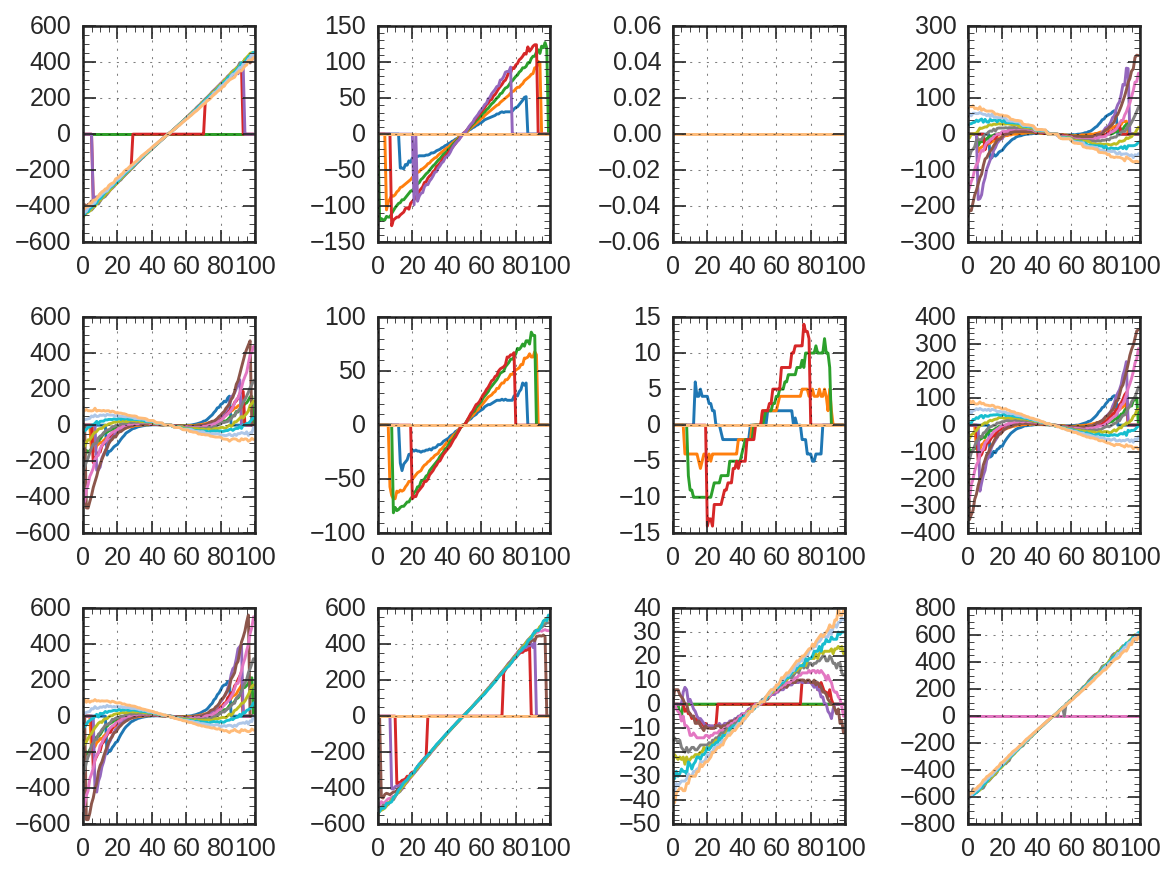

In [13]:
# w.r.t ME2
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(12):
    yy = patterns_match_me2_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

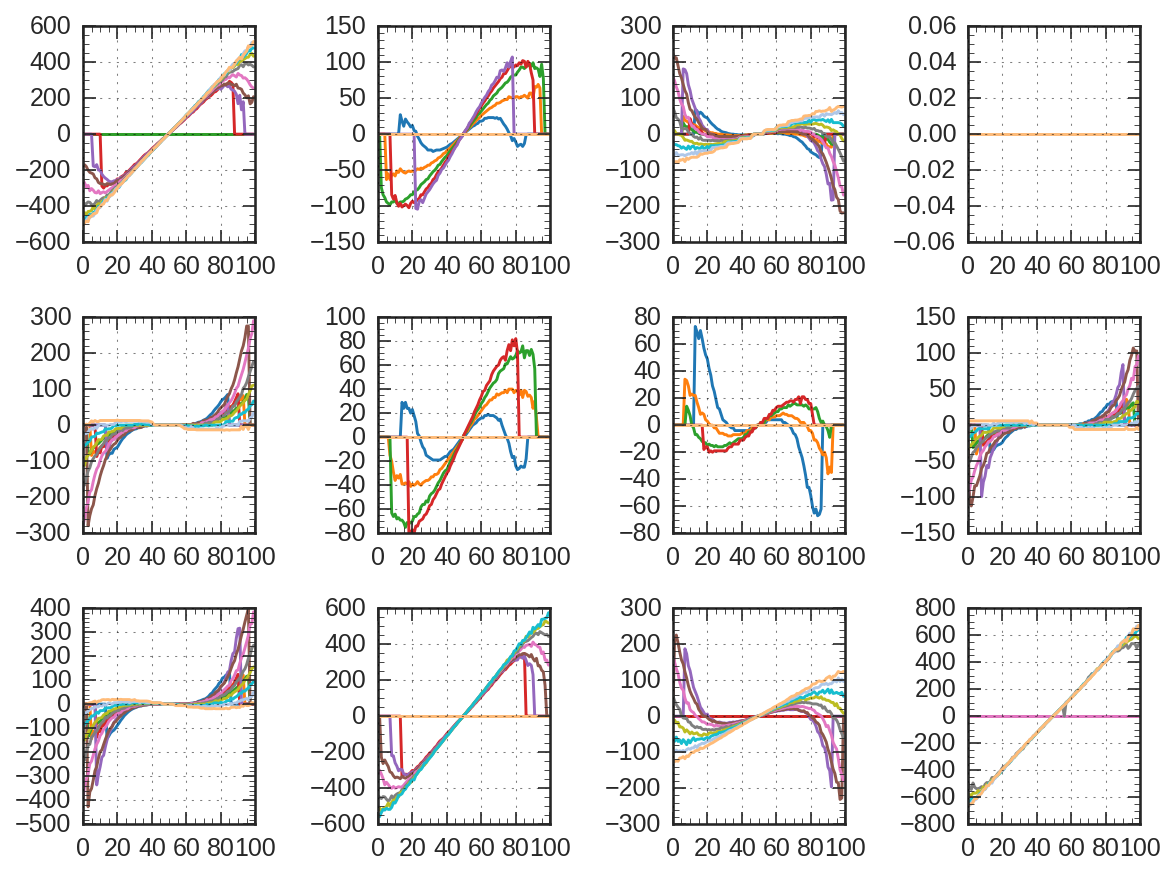

In [14]:
# w.r.t ME3
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(12):
    yy = patterns_match_me3_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

In [15]:
# Smoothing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
#kernel = C(10000.0, (1e-2, 1e7)) * RBF(1.0, (1e-2, 1e2)) + W(1.0, (1e-5, 1e5))
#gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10)

patterns_match_me2_2 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_2 = np.zeros(patterns_match_me3.shape, dtype=np.int32)

In [16]:
# ME1/1 w.r.t ME2, ME3

emtf_layer_me1 = 0

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(3,12):  # ME1/1, valid for eta >= 1.5
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 40
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,3,emtf_layer_me1] = patterns_match_me2_2[:,4,emtf_layer_me1]
patterns_match_me3_2[:,3,emtf_layer_me1] = patterns_match_me3_2[:,4,emtf_layer_me1]

0,(1.5,1.6) 28 (32725.000610589545, 0.003341312872700263)
0,(1.6,1.7) 26 (164268.5371051953, 0.4405052981269111)
0,(1.7,1.8) 23 (281678.4740679462, 0.5684251853095561)
0,(1.8,1.9) 21 (290525.2466128988, 0.5576503188013022)
0,(1.9,2.0) 18 (119436.6799922523, 0.4212972781904669)
0,(2.0,2.1) 14 (458221.05689460225, 0.6983227554319199)
0,(2.1,2.2) 10 (471278.14981074573, 0.7599396394508156)
0,(2.2,2.3) 6 (365845.6202126391, 0.7240953896171771)
0,(2.3,2.4) 1 (410698.41531535605, 0.7916926068586088)
1,(1.5,1.6) 28 (594727.235340297, 1.5)
1,(1.6,1.7) 26 (640945.9074052365, 1.5)
1,(1.7,1.8) 23 (236697.060636148, 0.933472530712518)
1,(1.8,1.9) 21 (568517.613008051, 1.3845666662178853)
1,(1.9,2.0) 18 (685520.1184240662, 1.5)
1,(2.0,2.1) 14 (944399.0159931775, 1.5)
1,(2.1,2.2) 10 (1018251.2653895023, 1.5)
1,(2.2,2.3) 6 (1332156.5083106055, 1.1557779173550695)
1,(2.3,2.4) 1 (253459.49403708312, 0.5998275948894002)


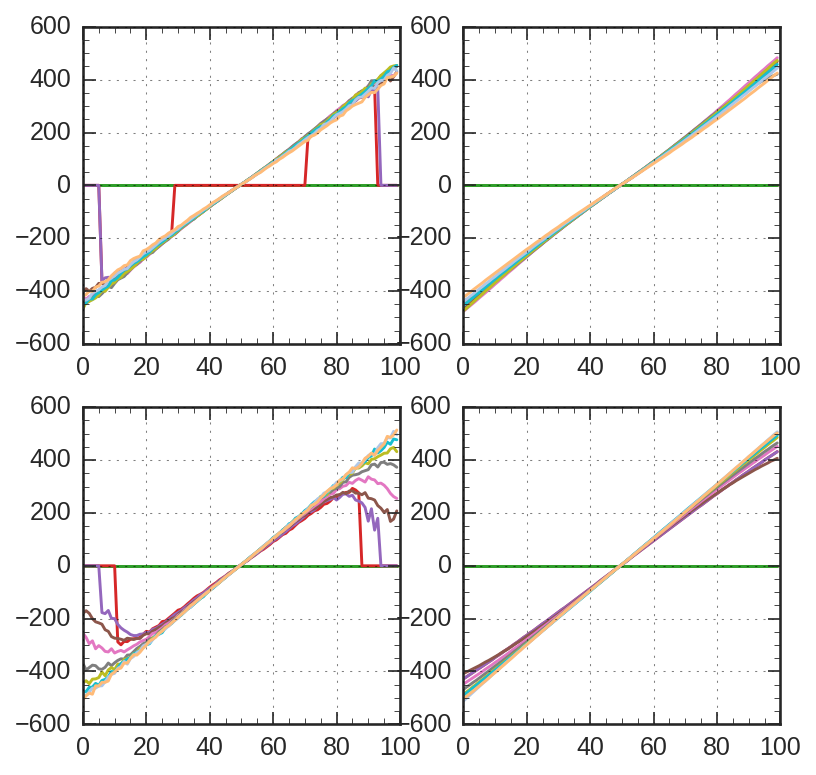

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [18]:
# ME0 w.r.t ME2, ME3

emtf_layer_me1 = 11

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(8,12):  # ME0, valid for eta >= 2.0
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 40
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,7,emtf_layer_me1] = patterns_match_me2_2[:,8,emtf_layer_me1]
patterns_match_me3_2[:,7,emtf_layer_me1] = patterns_match_me3_2[:,8,emtf_layer_me1]

0,(2.0,2.1) 14 (614527.5691020164, 0.6315573682525627)
0,(2.1,2.2) 10 (554084.2625362204, 0.6401269451938365)
0,(2.2,2.3) 6 (549943.6736040417, 0.658442712400489)
0,(2.3,2.4) 1 (1039234.4376264007, 0.8848064668275645)
1,(2.0,2.1) 14 (1884812.6474660218, 1.0367569029246595)
1,(2.1,2.2) 10 (3000000.0000000023, 1.3425311997417189)
1,(2.2,2.3) 6 (437373.1654683057, 0.5850527781759175)
1,(2.3,2.4) 1 (485391.8402619659, 0.6296485442681674)


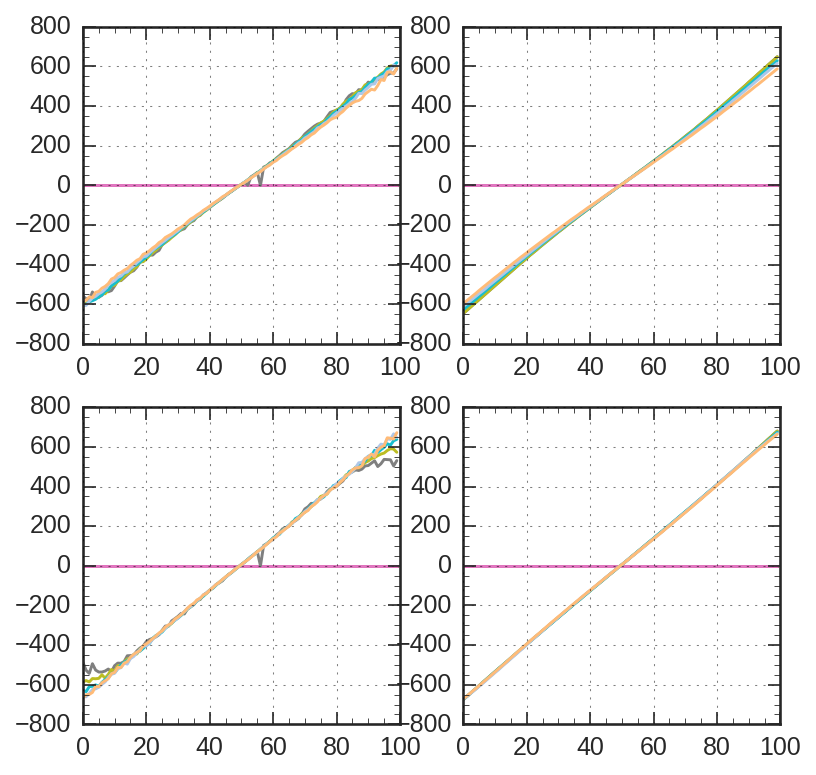

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [20]:
# GE1/1 w.r.t ME2, ME3

emtf_layer_me1 = 9

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(3,10):  # GE1/1, valid for 1.5 <= eta <= 2.2
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 60
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,3,emtf_layer_me1] = patterns_match_me2_2[:,4,emtf_layer_me1]
patterns_match_me3_2[:,3,emtf_layer_me1] = patterns_match_me3_2[:,4,emtf_layer_me1]
patterns_match_me2_2[:,9,emtf_layer_me1] = patterns_match_me2_2[:,8,emtf_layer_me1]
patterns_match_me3_2[:,9,emtf_layer_me1] = patterns_match_me3_2[:,8,emtf_layer_me1]

0,(1.5,1.6) 28 (49669.002546651696, 0.007822108335393402)
0,(1.6,1.7) 26 (253471.83921645803, 0.44660108326686215)
0,(1.7,1.8) 23 (413087.7555058169, 0.5564319097381422)
0,(1.8,1.9) 21 (428067.63230069086, 0.5596322206427099)
0,(1.9,2.0) 18 (391866.1406009616, 0.5734945930177272)
0,(2.0,2.1) 14 (663057.7312279743, 0.6940381731208524)
0,(2.1,2.2) 10 (800539.5321920501, 0.7586320784706847)
1,(1.5,1.6) 28 (873998.7139906319, 1.5)
1,(1.6,1.7) 26 (945887.6504730206, 1.5)
1,(1.7,1.8) 23 (617945.8161538072, 1.2276142114557018)
1,(1.8,1.9) 21 (981953.7728152212, 1.5)
1,(1.9,2.0) 18 (1006218.5487603816, 1.5)
1,(2.0,2.1) 14 (2041049.5164872902, 1.5)


/home/jlow/L1MuonTrigger/PostProcessJobs/CMSSW_10_1_7/src/venv/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 1.44373407e-05, -6.12525915e-01]), 'nit': 12, 'funcalls': 54}
  " state: %s" % convergence_dict)


1,(2.1,2.2) 10 (2754724.084930045, 1.5)


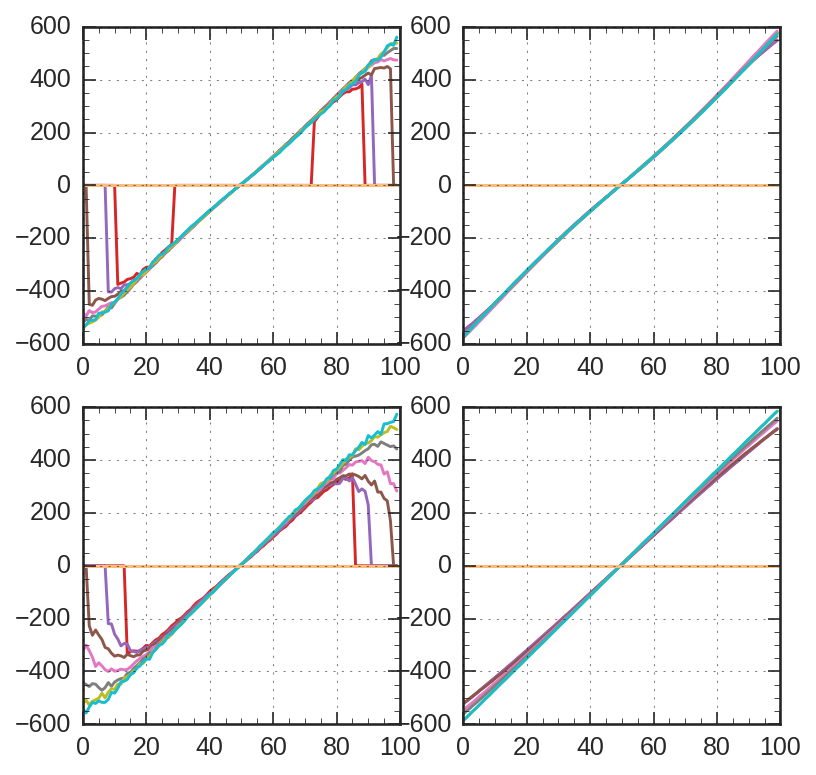

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [22]:
# ME1/2 w.r.t ME2, ME3

emtf_layer_me1 = 1

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(5):  # ME1/2, valid for eta <= 1.6
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1 + 4
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 40
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,4,emtf_layer_me1] = patterns_match_me2_2[:,3,emtf_layer_me1]
patterns_match_me3_2[:,4,emtf_layer_me1] = patterns_match_me3_2[:,3,emtf_layer_me1]

0,(1.2,1.3) 38 (383.4286495468529, 0.18547849598507604)
0,(1.3,1.4) 36 (1754.0793241646256, 0.3235491499757608)
0,(1.4,1.5) 34 (5490.958095662518, 0.47614244979157444)
0,(1.5,1.6) 32 (16436.589337813184, 0.7044277971108813)
0,(1.6,1.7) 30 (48700.89170512383, 1.0917387036993391)
1,(1.2,1.3) 38 (466.85341382123374, 0.17624726856843728)
1,(1.3,1.4) 36 (2160.9510902765533, 0.3023667865667827)
1,(1.4,1.5) 34 (7657.886551562427, 0.46725565861764407)
1,(1.5,1.6) 32 (17359.591473247157, 0.5931700332980941)
1,(1.6,1.7) 30 (33784.685528552494, 0.7628955980855983)


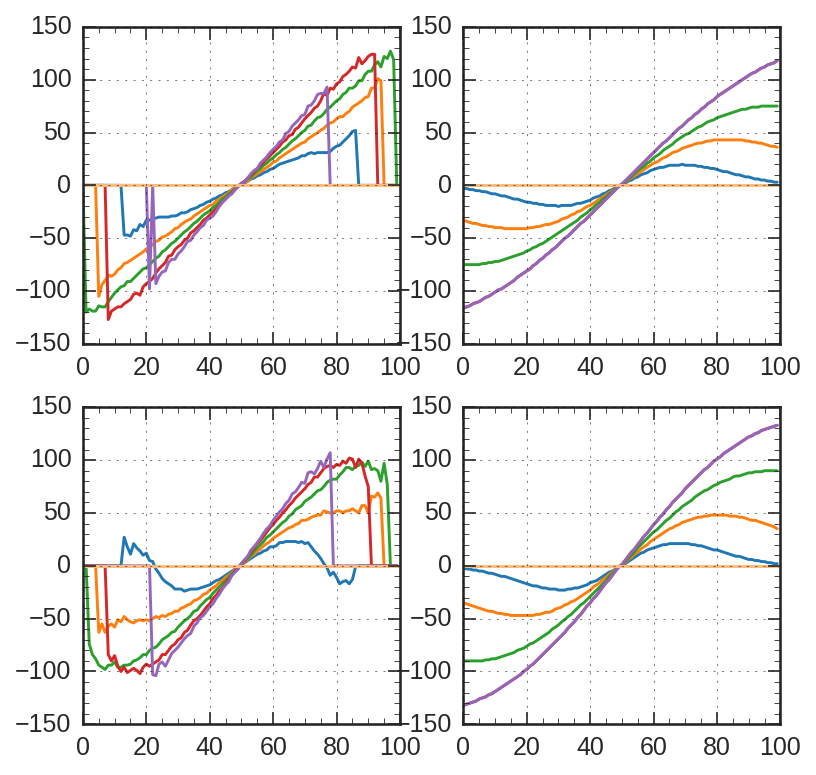

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

### Find pattern windows

In [24]:
%%time

np.random.seed(2023)

_get_emtf_phi = lambda x: x[1]

patterns_phi = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
patterns_match = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_phi.shape):
  patterns_phi[ind] = []
  patterns_match[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, mode) = part
  hits = hits[hits[:,0] != -99]
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta12 = find_eta_bin_12(part_eta)
  ipt = find_pt_bin(part_invpt)
  ieta = find_eta_bin(part_eta)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    amap.setdefault(hit[0], []).append(hit)
      
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

  # Find hit phi at the key station
  key_hit_phi = None
  
  def _get_dphi():
    dphi = patterns_match_me2_2[ipt100, ieta12, emtf_layer_me1]
    dphi += patterns_match_me3_2[ipt100, ieta12, emtf_layer_me1]
    dphi *= 0.5
    dphi *= (np.sinh(1.8587) / np.sinh(abs(part_eta)))
    return dphi
  
  if key_hit_phi is None:
    emtf_layer_me1 = 0  # ME1/1
    hit2 = amap.get(emtf_layer_me1, None)
    if hit2 is not None:
      key_hit_phi = _get_emtf_phi(hit2)
      dphi = _get_dphi()
      key_hit_phi -= dphi
  
  if key_hit_phi is None:
    emtf_layer_me1 = 11  # ME0
    hit2 = amap.get(emtf_layer_me1, None)
    if hit2 is not None:
      key_hit_phi = _get_emtf_phi(hit2)
      dphi = _get_dphi()
      key_hit_phi -= dphi
    
  if key_hit_phi is None:
    emtf_layer_me1 = 9  # GE1/1
    hit2 = amap.get(emtf_layer_me1, None)
    if hit2 is not None:
      key_hit_phi = _get_emtf_phi(hit2)
      dphi = _get_dphi()
      key_hit_phi -= dphi
      
  if key_hit_phi is None:
    emtf_layer_me1 = 1  # ME1/2
    hit2 = amap.get(emtf_layer_me1, None)
    if hit2 is not None:
      key_hit_phi = _get_emtf_phi(hit2)
      dphi = _get_dphi()
      key_hit_phi -= dphi
      
  if key_hit_phi is None:
    continue
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    dphi = (hit_phi1 - key_hit_phi)
    patterns_phi[ipt, int(zone), emtf_layer].append(dphi)
    
    emtf_layer_partner = find_emtf_layer_partner(emtf_layer, zone)
    hit2 = amap.get(emtf_layer_partner, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = (hit_phi1 - hit_phi2)
      patterns_match[ipt, int(zone), emtf_layer].append(dphi)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 8min 36s, sys: 5.14 s, total: 8min 41s
Wall time: 8min 31s


In [25]:
valid_layers = np.zeros(patterns_phi.shape, dtype=np.bool)
valid_layers[:, 0, [0,2,3,4,7,8,10,11]]   = True
valid_layers[:, 1, [0,2,3,4,7,8,9,10,11]] = True
valid_layers[:, 2, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 3, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 4, [0,1,2,3,4,7,8,9,10]]  = True
valid_layers[:, 5, [1,2,3,4,5,6,7,8]]     = True

# Histogram
# - make 47 bins, bin 23 is the highest pT
nbinsx = 47
firstbinx = 23
xlow = -0.5*nbinsx*superstrip_size
xup = +0.5*nbinsx*superstrip_size

patterns_phi_1 = np.zeros(patterns_phi.shape + (nbinsx,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    
    patterns_phi_1[ind], _ = np.histogram(patterns_phi[ind], bins=nbinsx, range=(xlow,xup))
    
# Strange bug
if patterns_phi_1[0,4,0,firstbinx] > 0:
  print patterns_phi_1[:,:,0,firstbinx]
  patterns_phi_1[0,4,0,firstbinx] = 0
  patterns_phi_1[1,4,0,firstbinx] = 0
  patterns_phi_1[7,4,0,firstbinx] = 0
  patterns_phi_1[8,4,0,firstbinx] = 0

[[    0     0     0     0   436     0]
 [    0     0     0     0    10     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     1     0]
 [20689 11086 12604  6943  7327     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0    13     0]
 [    0     0     0     0   350     0]]


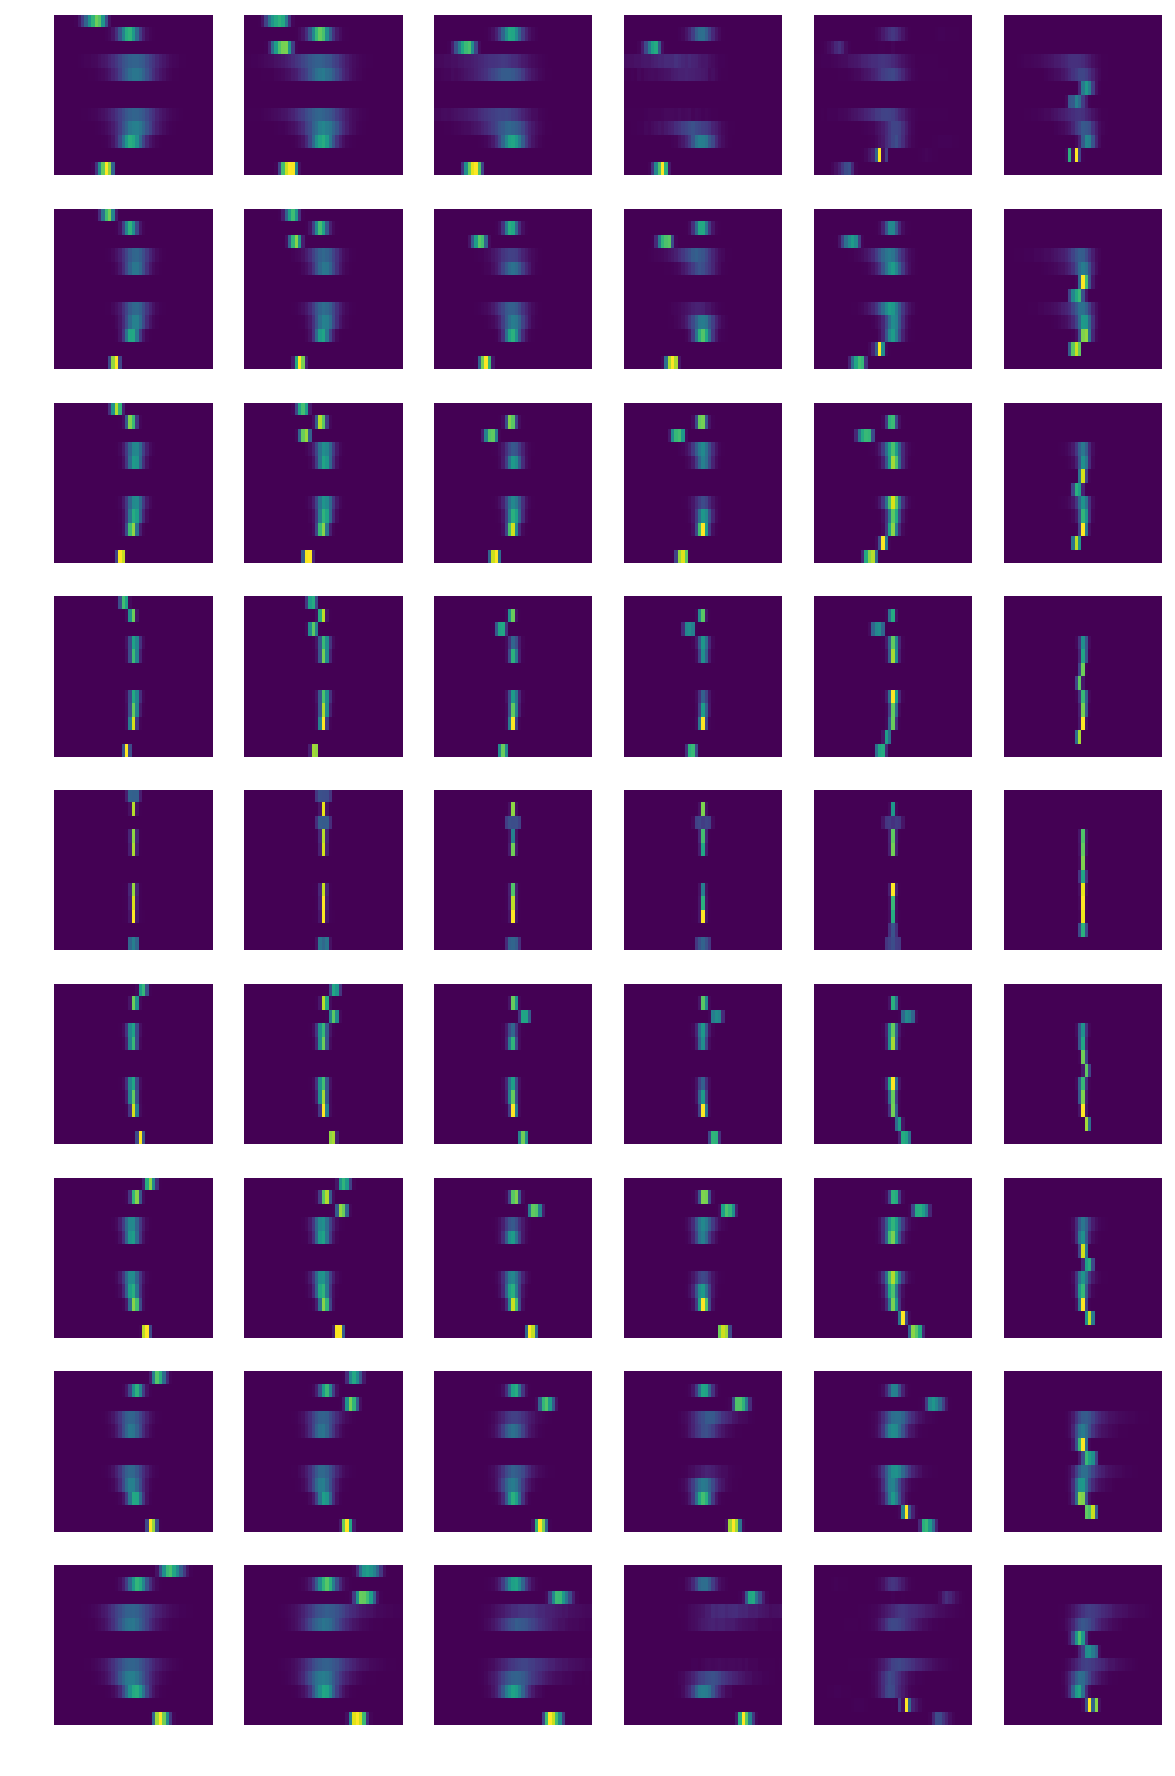

In [26]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    img = patterns_phi_1[i,j,:]
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [27]:
patterns_phi_2 = np.zeros(patterns_phi.shape + (3,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    
    x = patterns_phi_1[ind].copy().astype(np.int64)
    #norm = x.sum()
    norm = np.sqrt(np.square(x).sum())
    assert(np.isfinite(norm).all())
    x = np.true_divide(x, norm)
    x[np.isnan(x)] = 0
    
    try:
      #y = np.where(x > 0.01)[0]
      #y = np.where(x > 0.1)[0]
      if ind[2] in [5,6,7,8]:  # cut harder on RPC
        y = np.where(x > 0.16)[0]
      else:
        y = np.where(x > 0.12)[0]
      if (y[-1] - y[0]) != len(y)-1:
        print("[WARNING] The range is not continuous. Please check!")
      y = y[0] - firstbinx, y[-1] - firstbinx  # offset by firstbinx
    except:
      y = 0, 0
    
    z = np.percentile(patterns_phi[ind], [2.5,50,97.5], overwrite_input=True)
    z = np.round(np.true_divide(z, superstrip_size))
    print ind, y, z
    
    patterns_phi_2[ind] = y[0], z[1], y[1]
    
print patterns_phi_2.min(), patterns_phi_2.max()

(0, 0, 0) (-10, -6) [-11.  -8.  -6.]
(0, 0, 2) (-4, 3) [-6. -1.  5.]
(0, 0, 3) (-4, 5) [-7.  1.  8.]
(0, 0, 4) (-6, 6) [-10.   0.   9.]
(0, 0, 7) (-4, 5) [-8.  1.  9.]
(0, 0, 8) (-5, 6) [-11.   0.  10.]
(0, 0, 10) (-4, 2) [-6. -1.  3.]
(0, 0, 11) (-14, -8) [-15. -11.  -8.]
(0, 1, 0) (-12, -8) [-13. -10.  -8.]
(0, 1, 2) (-4, 3) [-6. -0.  5.]
(0, 1, 3) (-5, 5) [-9. -0.  8.]
(0, 1, 4) (-8, 5) [-15.  -1.   8.]
(0, 1, 7) (-5, 5) [-11.  -1.   8.]
(0, 1, 8) (-8, 4) [-17.  -2.   8.]
(0, 1, 9) (-15, -10) [-15. -12.  -9.]
(0, 1, 10) (-4, 2) [-5. -1.  4.]
(0, 1, 11) (-17, -11) [-17. -13. -10.]
(0, 2, 0) (-14, -10) [-15. -12.  -9.]
(0, 2, 2) (-4, 4) [-6. -0.  6.]
(0, 2, 3) (-8, 4) [-14.  -2.   7.]
(0, 2, 4) (-12, 3) [-24.  -5.   6.]
(0, 2, 7) (-8, 3) [-18.  -3.   6.]
(0, 2, 8) (-11, 2) [-28.  -6.   6.]
(0, 2, 9) (-17, -11) [-17. -14. -11.]
(0, 2, 10) (-4, 3) [-5. -1.  4.]
(0, 3, 0) (-14, -11) [-15. -12. -11.]
(0, 3, 2) (-4, 4) [-6. -0.  5.]
(0, 3, 3) (-10, 3) [-16.  -3.   5.]
(0, 3, 4) (-16, 2) [-

In [28]:
import contextlib

# Answer from https://stackoverflow.com/a/2891805
@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally:
        np.set_printoptions(**original)

In [29]:
if False:
  zone = 4
  emtf_layer = 8
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.int64)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    print x.shape
    print x[4,emtf_layer], np.where(x[4,emtf_layer] > 0.12)[0] - firstbinx
    print x[5,emtf_layer], np.where(x[5,emtf_layer] > 0.12)[0] - firstbinx
    print x[6,emtf_layer], np.where(x[6,emtf_layer] > 0.12)[0] - firstbinx
    print x[7,emtf_layer], np.where(x[7,emtf_layer] > 0.12)[0] - firstbinx
    print x[8,emtf_layer], np.where(x[8,emtf_layer] > 0.12)[0] - firstbinx

In [30]:
if False:
  zone = 5
  emtf_layer = 1
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.int64)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    print x.shape
    print x[4,emtf_layer], np.where(x[4,emtf_layer] > 0.12)[0] - firstbinx
    print x[3,emtf_layer], np.where(x[3,emtf_layer] > 0.12)[0] - firstbinx
    print x[2,emtf_layer], np.where(x[2,emtf_layer] > 0.12)[0] - firstbinx
    print x[1,emtf_layer], np.where(x[1,emtf_layer] > 0.12)[0] - firstbinx
    print x[0,emtf_layer], np.where(x[0,emtf_layer] > 0.12)[0] - firstbinx

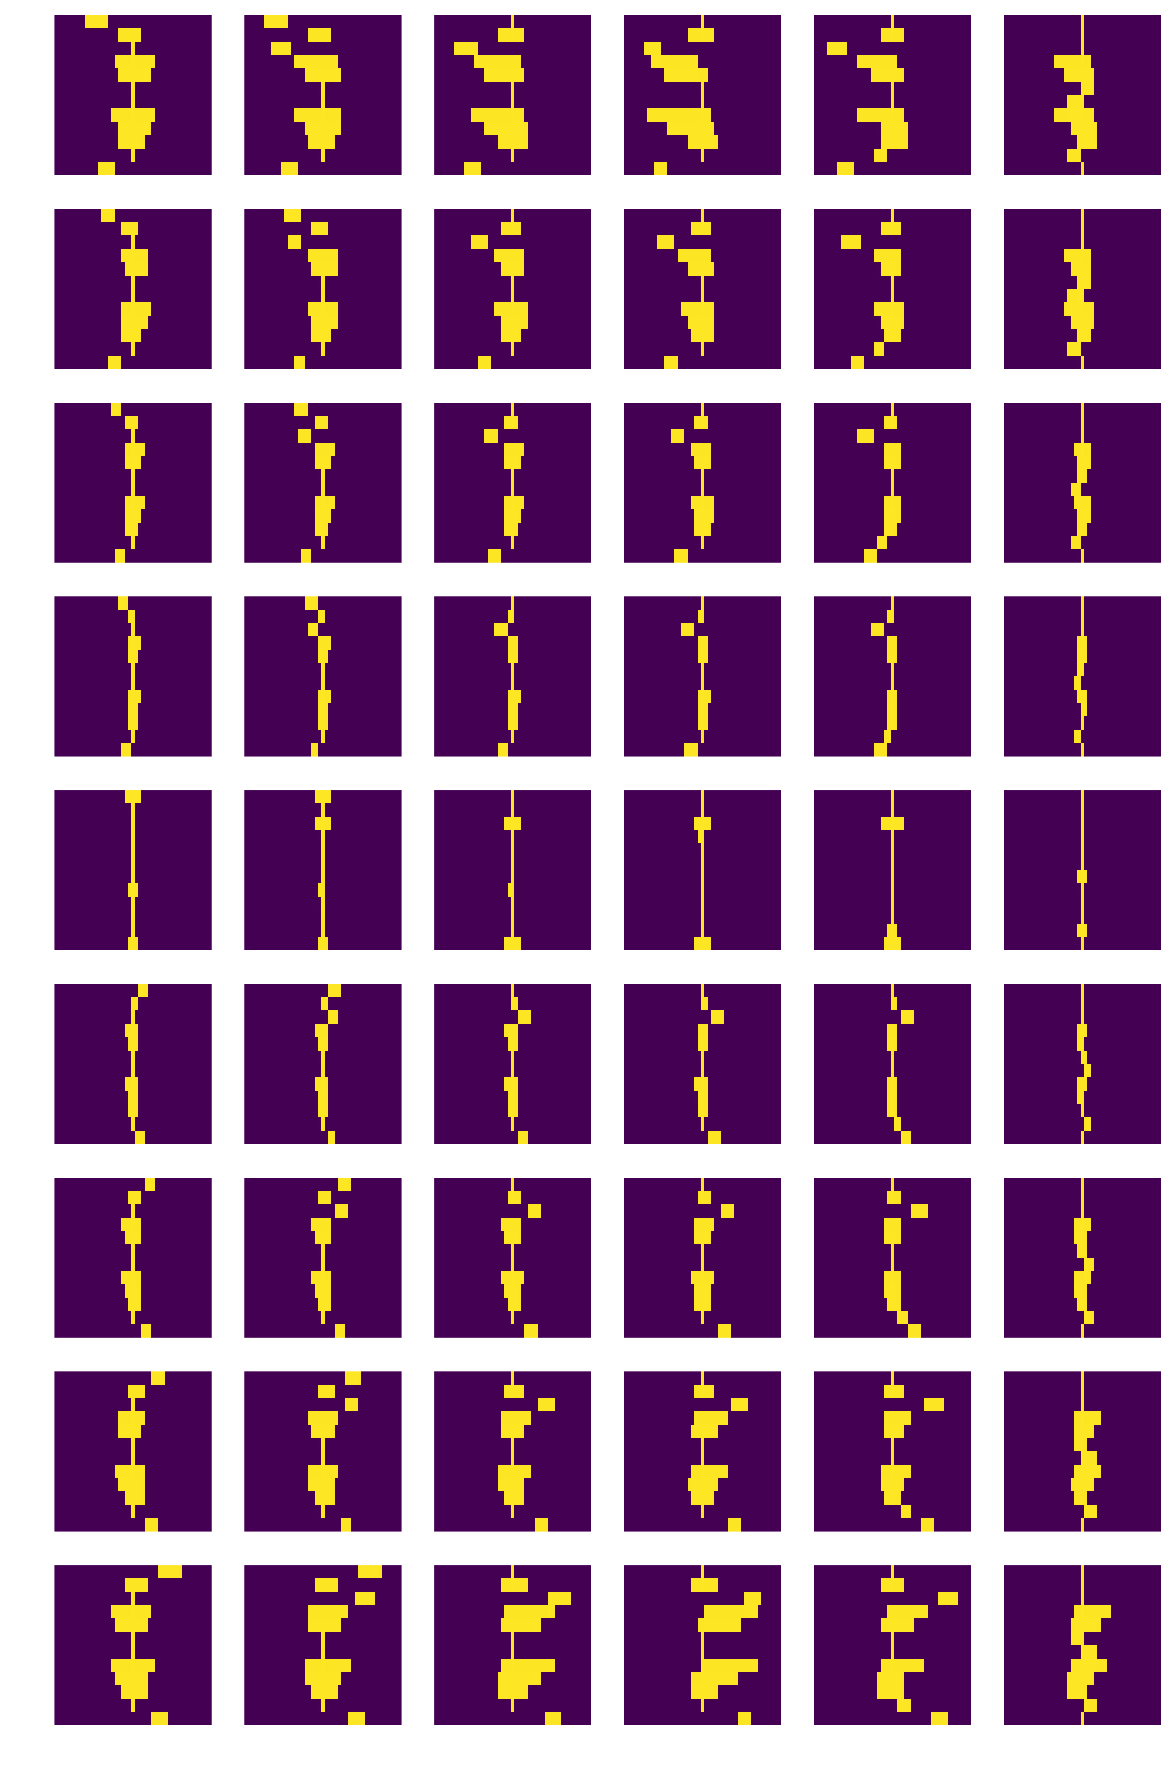

In [31]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    img = np.zeros((nlayers, nbinsx), dtype=np.float32)
    for k in xrange(nlayers):
      x0, x1 = patterns_phi_2[i,j,k,0] + firstbinx, patterns_phi_2[i,j,k,2] + firstbinx  # offset by firstbinx
      img[k, slice(x0,x1+1)] = 1

    axs[i,j].imshow(img, origin='lower', interpolation='none', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [32]:
patterns_match_1 = np.zeros(patterns_match.shape + (3,), dtype=np.int32)

for ind in np.ndindex(patterns_match.shape):
  if valid_layers[ind]:
    patterns_match_1[ind] = np.percentile(patterns_match[ind], [5, 50, 95], overwrite_input=True)
    print ind, patterns_match_1[ind]

(0, 0, 0) [-400 -238 -110]
(0, 0, 2) [110 238 400]
(0, 0, 3) [ 90 273 491]
(0, 0, 4) [ 35 269 523]
(0, 0, 7) [-32   0  24]
(0, 0, 8) [-38  -4  18]
(0, 0, 10) [-56 -20   2]
(0, 0, 11) [-144  -92  -50]
(0, 1, 0) [-489 -310 -172]
(0, 1, 2) [172 310 489]
(0, 1, 3) [111 318 544]
(0, 1, 4) [-24 270 535]
(0, 1, 7) [-66 -12  12]
(0, 1, 8) [-74 -16   8]
(0, 1, 9) [-96 -65 -38]
(0, 1, 10) [-55 -18   9]
(0, 1, 11) [-163 -114  -70]
(0, 2, 0) [-547 -365 -217]
(0, 2, 2) [217 365 547]
(0, 2, 3) [ 43 312 543]
(0, 2, 4) [-225  211  492]
(0, 2, 7) [-146  -34    0]
(0, 2, 8) [-134  -34    0]
(0, 2, 9) [-107  -79  -50]
(0, 2, 10) [-47 -10  30]
(0, 3, 0) [-542 -382 -236]
(0, 3, 2) [236 382 542]
(0, 3, 3) [ -7 283 509]
(0, 3, 4) [-263  144  463]
(0, 3, 7) [-226  -68  -12]
(0, 3, 8) [-122  -42   -5]
(0, 3, 9) [-111  -86  -59]
(0, 3, 10) [-35  -2  40]
(0, 4, 0) [-607 -440 -306]
(0, 4, 1) [-240 -170 -104]
(0, 4, 2) [306 440 607]
(0, 4, 3) [198 394 579]
(0, 4, 4) [-42 281 530]
(0, 4, 7) [-90 -29   0]
(0, 4, 8) 

In [33]:
outfile = 'histos_tb.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi_2, patterns_match=patterns_match_1)

In [34]:
loaded = np.load('histos_tb.npz')
print loaded['patterns_phi'].shape
print loaded['patterns_match'].shape

(9, 6, 12, 3)
(9, 6, 12, 3)


In [35]:
print loaded['patterns_phi'][:,1,:5]
print loaded['patterns_match'][:,1,:5]

[[[-12 -10  -8]
  [  0   0   0]
  [ -4   0   3]
  [ -5   0   5]
  [ -8  -1   5]]

 [[ -8  -7  -6]
  [  0   0   0]
  [ -3   0   2]
  [ -3   0   4]
  [ -4   0   4]]

 [[ -6  -5  -4]
  [  0   0   0]
  [ -2   0   1]
  [ -2   0   2]
  [ -2   0   3]]

 [[ -3  -3  -2]
  [  0   0   0]
  [ -1   0   1]
  [ -1   0   1]
  [ -1   0   2]]

 [[ -1   0   1]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [ -1   0   0]]

 [[  2   3   3]
  [  0   0   0]
  [ -1   0   1]
  [ -1   0   1]
  [ -2   0   1]]

 [[  4   5   6]
  [  0   0   0]
  [ -1   0   2]
  [ -2   0   2]
  [ -3   0   2]]

 [[  6   7   8]
  [  0   0   0]
  [ -2   0   3]
  [ -4   0   3]
  [ -4   0   4]]

 [[  8  10  12]
  [  0   0   0]
  [ -3   0   4]
  [ -5   0   5]
  [ -5   1   8]]]
[[[-489 -310 -172]
  [   0    0    0]
  [ 172  310  489]
  [ 111  318  544]
  [ -24  270  535]]

 [[-314 -209 -123]
  [   0    0    0]
  [ 123  209  314]
  [ 113  233  369]
  [  76  224  384]]

 [[-209 -135  -78]
  [   0    0    0]
  [  78  135  209]
  [  80  15